# **Corrección datos SEV**

Autores

- **Daniela Quintero**: [yejoandajudi200305@gmail.com](mailto:yejoandajudi200305@gmail.com)
- **Paul Goyes**: [goyes.yesid@gmail.com](mailto:goyes.yesid@gmail.com)  

Importar las librerías necesarias

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from discretize import TensorMesh
from scipy.constants import mu_0

# Pygimli
import pygimli as pg
from pygimli.physics import em
from pygimli.physics.em import rhoafromU
from pygimli.physics.em import VMDTimeDomainModelling
from pygimli.viewer.mpl import drawModel1D

# SimPEG
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)
from simpeg.electromagnetics.static import resistivity as dc
import simpeg.electromagnetics.time_domain as tdem
from simpeg.utils import plot_1d_layer_model, download, mkvc

mpl.rcParams.update({"font.size": 16})

# Modelamiento SEV

In [2]:
dobsSEV = np.array([ 43.025,  65.821,  91.297, 102.94 , 108.34 , 116.88 , 105.47 ,
        73.699,  86.071,  68.475,  72.662,  77.574,  72.827,  74.94 ,
        81.644,  76.599,  76.703,  83.44 ,  69.359])
ab2 = np.array([ 2,  4,  8, 10, 10, 20, 25, 35, 40, 50, 55, 55, 60, 75, 80, 80, 85,
       90, 95])

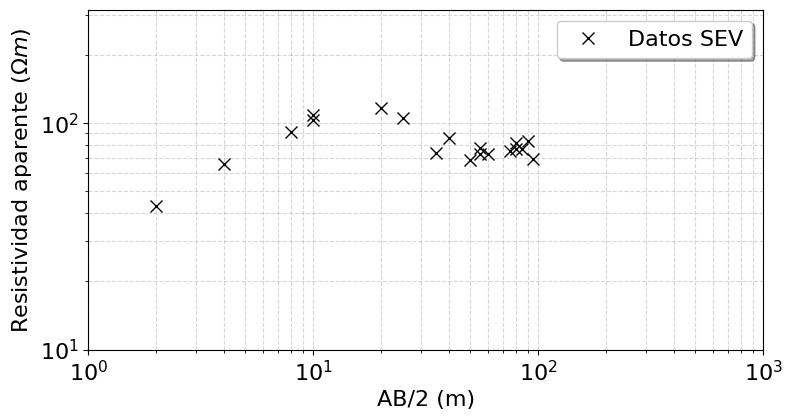

In [3]:
# Graficar la curva de resistividad aparente
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax1.loglog(ab2, dobsSEV, color="black", label="Datos SEV", marker="x", markersize=8, lw=2, linestyle='none')
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Resistividad aparente ($\Omega m$)")
ax1.set_ylim([10**1, 10**2.5])
ax1.set_xlim([10**0, 10**3])
ax1.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
plt.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)
plt.savefig("DatosSEVPiedecuesta.svg", dpi=300, bbox_inches='tight', format='svg')
plt.show()

In [4]:
datas = em.readusffile('DatosSEV_TDEM/20240901_110436_937_Station1.usf')


NSWEEPS = len(datas)
COILSIZE1=35 #0.5×0.5 en el RC-5
COILSIZE2=1400 # 10×10 en la RC-200

dbdts1, dbdts2, dbdts4, dbdts5= [], [], [], []
tiempo_1, tiempo_2, tiempo_4, tiempo_5= [], [], [], []

for sweep in datas:
    if sweep['CURRENT'] != 0:
        channel = int(sweep['CHANNEL'])
        voltage = sweep['VOLTAGE']
        current = sweep['CURRENT']
        time = sweep['TIME']
        coil_size = sweep['COIL_SIZE']

        if channel == 1:
            dbdts1.append(voltage)
            tiempo_1.append(time)
        elif channel == 2:
            dbdts2.append(voltage)
            tiempo_2.append(time)
        elif channel == 4:
            dbdts4.append(voltage)
            tiempo_4.append(time)
        elif channel == 5:
            dbdts5.append(voltage)
            tiempo_5.append(time)

In [5]:
# RC-5 LM
dbdt_1 = np.array(dbdts1)
dbdt_RC5_Low= np.nanmean(dbdt_1,axis=0)

# RC-5 HM
dbdt_2 = np.array(dbdts2)
dbdt_RC5_High= np.nanmean(dbdt_2,axis=0)

# RC-200 LM
dbdt_4 = np.array(dbdts4)
dbdt_RC200_Low= np.nanmean(dbdt_4,axis=0)

# RC-200 HM
dbdt_5 = np.array(dbdts5)
dbdt_RC200_High= np.nanmean(dbdt_5,axis=0)

# Calcular el promedio de las LM
dbdt_low = np.mean([dbdt_RC5_Low, dbdt_RC200_Low], axis=0)

# Calcular el promedio de las HM
dbdt_high = np.mean([dbdt_RC5_High, dbdt_RC200_High], axis=0)

# RC-5 LM
tiempo1 = np.array(tiempo_1)
tiempo_RC5_Low= np.nanmean(tiempo1,axis=0)

# RC-5 HM
tiempo2 = np.array(tiempo_2)
tiempo_RC5_High= np.nanmean(tiempo2,axis=0)

# RC-200 LM
tiempo4 = np.array(tiempo_4)
tiempo_RC200_Low= np.nanmean(tiempo4,axis=0)

# RC-200 HM
tiempo5 = np.array(tiempo_5)
tiempo_RC200_High= np.nanmean(tiempo5,axis=0)

# Calcular el promedio de las LM
tiempo_low = np.mean([tiempo_RC5_Low, tiempo_RC200_Low], axis=0)

# Calcular el promedio de las HM
tiempo_high = np.mean([tiempo_RC5_High, tiempo_RC200_High], axis=0)

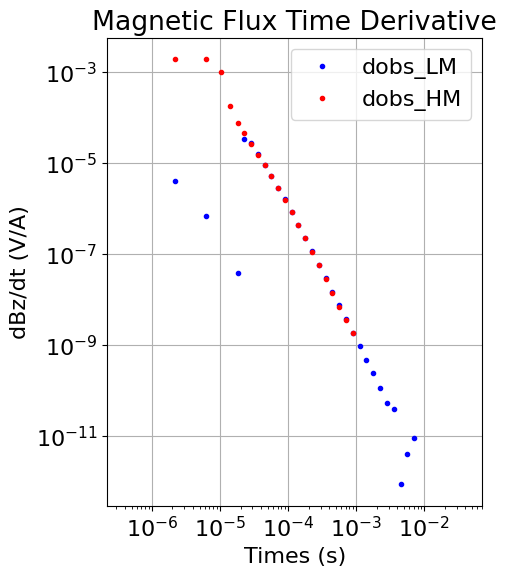

In [6]:
fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])

ax.loglog(tiempo_low, dbdt_low, "b.",  label='dobs_LM')
ax.loglog(tiempo_high, dbdt_high, "r.", label='dobs_HM')

ax.set_xlim([tiempo_low.min()/10, 10*tiempo_low.max()])

ax.grid()
ax.set_xlabel("Times (s)")
ax.set_ylabel("dBz/dt (V/A)")
ax.set_title("Magnetic Flux Time Derivative")
ax.legend()
plt.show()

In [7]:
#Ajustar los dobs
dobs_LM = np.array([ 3.38525472e-05, 2.76701437e-05, 1.57618070e-05,
                     9.17713027e-06, 5.20997792e-06, 2.82605358e-06, 1.57008920e-06,
                     8.30184820e-07, 4.36890438e-07, 2.24103082e-07, 1.14162041e-07,
                     5.83687640e-08, 2.94639193e-08, 1.48223855e-08, 7.45800835e-09,
                     3.71896198e-09, 1.87989941e-09, 9.80784310e-10, 4.76401069e-10,])
time_LM = np.array([
                      2.26900e-05, 2.86900e-05, 3.61900e-05, 4.51900e-05, 5.66900e-05,
                      7.11900e-05, 8.96900e-05, 1.13190e-04, 1.42190e-04, 1.79190e-04,
                      2.25690e-04, 2.83690e-04, 3.57190e-04, 4.49690e-04, 5.66190e-04,
                      7.12690e-04, 8.97190e-04, 1.12969e-03, 1.42219e-03])
dobs_LM.shape

(19,)

In [8]:
#Ajustar los dobs
dobs_HM = np.array([1.77050340e-04,
       7.56142867e-05, 4.49946855e-05, 2.59797362e-05, 1.49537570e-05,
       8.78385150e-06, 5.06012342e-06, 2.83882427e-06, 1.55434830e-06,
       8.27476090e-07, 4.32589608e-07, 2.23816416e-07, 1.12822144e-07,
       5.76702007e-08, 2.84472485e-08, 1.39132085e-08, 6.88137348e-09,
       3.63763404e-09, 1.87753891e-09])
time_HM = np.array([1.4190e-05, 1.8190e-05,
       2.2690e-05, 2.8690e-05, 3.6190e-05, 4.5190e-05, 5.6690e-05,
       7.1190e-05, 8.9690e-05, 1.1319e-04, 1.4219e-04, 1.7919e-04,
       2.2569e-04, 2.8369e-04, 3.5719e-04, 4.4969e-04, 5.6619e-04,
       7.1269e-04, 8.9719e-04])
dobs_HM.shape

(19,)

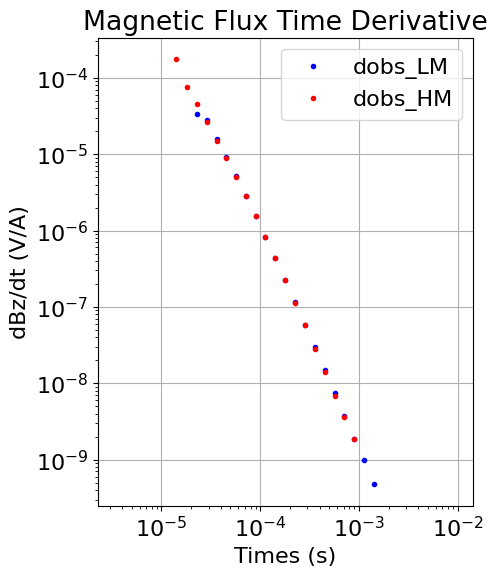

In [9]:
fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])

ax.loglog(time_LM, dobs_LM, "b.",  label='dobs_LM')
ax.loglog(time_HM, dobs_HM, "r.", label='dobs_HM')

ax.set_xlim([time_LM.min()/10, 10*time_LM.max()])
#ax.set_ylim([1e-12, 1e-3])

ax.grid()
ax.set_xlabel("Times (s)")
ax.set_ylabel("dBz/dt (V/A)")
ax.set_title("Magnetic Flux Time Derivative")
ax.legend()
plt.show()

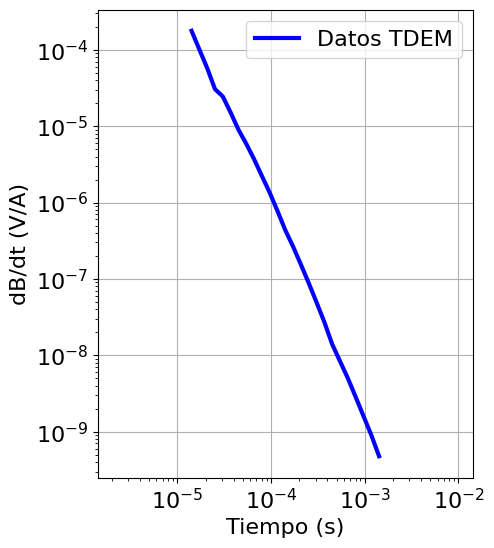

In [10]:
from scipy import interpolate
x = np.concatenate((time_HM, time_LM))
y = np.concatenate((dobs_HM, dobs_LM))
f = interpolate.interp1d(x, y)

times_ok = np.logspace(np.log10(np.min(time_HM)),np.log10(np.max(time_LM)),25)
dpredTDEM_ok = f(times_ok)   # use interpolation function returned by `interp1d`



fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])
ax.loglog(times_ok, dpredTDEM_ok, "b-", lw=3, label='Datos TDEM')
#ax.loglog(xnew, ynew, "r--", lw=3, label='dpred_HM')

#ax.loglog(time_LM, dobs_LM, "b.",  label='dobs_LM')
#ax.loglog(time_HM, dobs_HM, "r.", label='dobs_HM')

ax.set_xlim([time_HM.min()/10, 10*time_LM.max()])
#ax.set_ylim([1e-12, 1e-2])

ax.grid()
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel("dB/dt (V/A)")
#ax.set_title("Magnetic Flux Time Derivative")
ax.legend()
plt.show()

In [11]:
rhoa_TDEM = rhoafromU(U= dpredTDEM_ok, t= times_ok, Tx= 1600, Rx= 1)

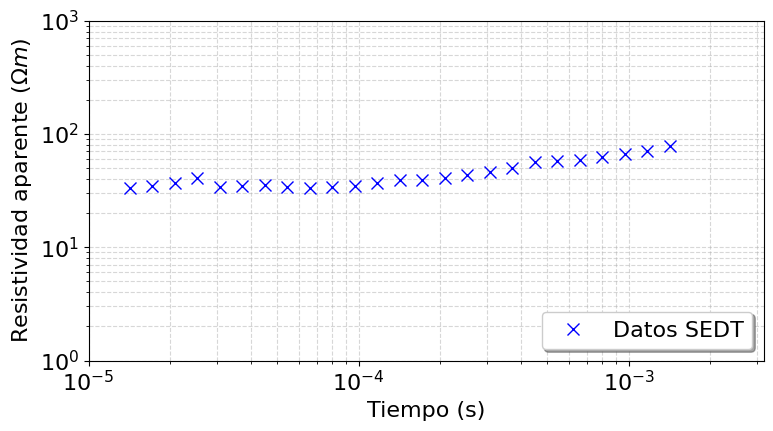

In [12]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax.loglog(times_ok, rhoa_TDEM, "b", marker="x", markersize=8, lw=2, linestyle='none', label='Datos SEDT')
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel(r"Resistividad aparente ($\Omega m$)")

ax.set_ylim([10**0, 10**3])
ax.set_xlim([10**-5, 10**-2.5])
ax.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
plt.legend(loc='lower right', frameon=True, shadow=True, fancybox=True)

#plt.tight_layout()
#plt.savefig("DatosSEDTPiedecuesta_Hidro.png", dpi=300, bbox_inches='tight', format='png')

#filename = "DatosSEDT.png"
#plt.savefig(filename, dpi=300, bbox_inches='tight', format='png')
plt.show()

In [13]:
rhoa_TDEM = np.array([32.97803107, 34.8412198 , 35.74851737, 35.7850486 , 34.31492049,
       34.38466984, 35.21462226, 33.98966739, 33.60238027, 34.21092576,
       34.77399838, 36.50796148, 38.98492071, 39.40644962, 41.07077412,
       43.3250973 , 46.29960584, 49.98935253, 56.58882757, 57.84263606,
       59.01750888, 62.43252015, 66.56639655, 70.78288249, 78.82827798])

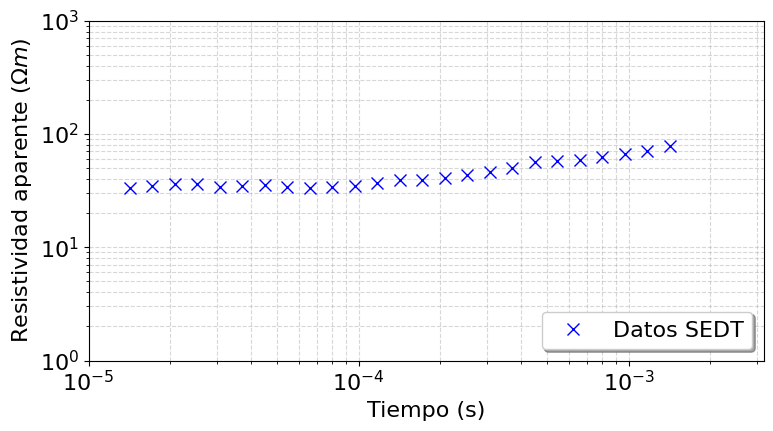

In [14]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax.loglog(times_ok, rhoa_TDEM, "b", marker="x", markersize=8, lw=2, linestyle='none', label='Datos SEDT')
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel(r"Resistividad aparente ($\Omega m$)")

ax.set_ylim([10**0, 10**3])
ax.set_xlim([10**-5, 10**-2.5])
ax.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
plt.legend(loc='lower right', frameon=True, shadow=True, fancybox=True)

#plt.tight_layout()
plt.savefig("SEDTPiedecuesta_Hidro.svg", dpi=300, bbox_inches='tight', format='svg')

#filename = "DatosSEDT.png"
#plt.savefig(filename, dpi=300, bbox_inches='tight', format='png')
plt.show()

In [15]:
# Convertir de tiempo a ab2
L = 711.8 * np.sqrt(times_ok * rhoa_TDEM)

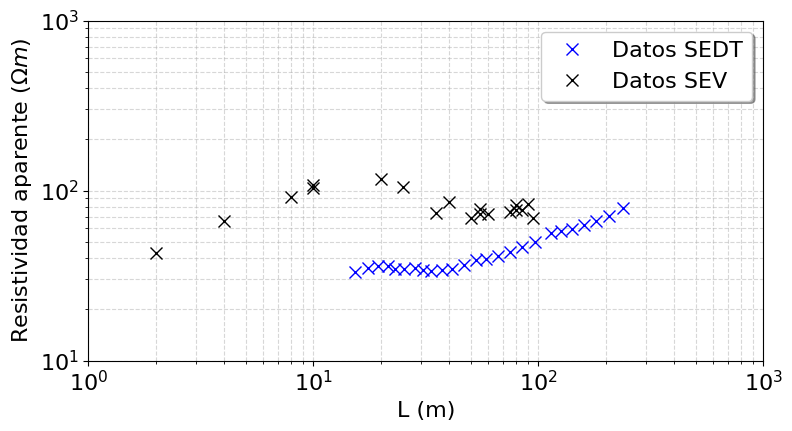

In [16]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_axes([0.1, 0.1, 0.75, 0.85])

ax.loglog(L, rhoa_TDEM, "blue",  label='Datos SEDT', marker="x",markersize=8, lw=2, linestyle='none')
ax.loglog(ab2, dobsSEV, "black", label='Datos SEV', marker="x", markersize=8,lw=2, linestyle='none')

ax.set_xlabel("L (m)")
ax.set_ylabel("Resistividad aparente ($\Omega m$)")

ax.set_ylim([10**1, 10**3])
ax.set_xlim([10**0, 10**3])
ax.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
plt.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)

#plt.tight_layout()

filename = "SEVStaticShiftPiedeucesta.svg"
plt.savefig(filename, dpi=300, bbox_inches='tight', format='svg')
plt.show()

# BOORAR DATOS SEDT

## Inversión electromagnética transitoria

Survey

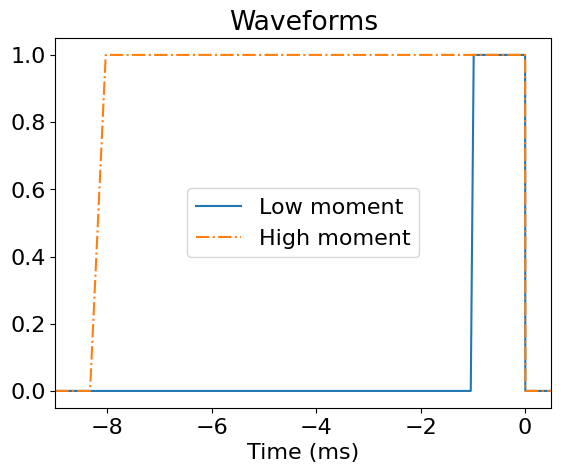

In [17]:
  # Low moment
lm_waveform_times = np.r_[-1.041E-03, -9.850E-04, 0.000E+00, 4.000E-06]
lm_waveform_current = np.r_[0.0, 1.0, 1.0, 0.0]

# High moment
hm_waveform_times = np.r_[-8.333E-03, -8.033E-03, 0.000E+00, 5.600E-06]
hm_waveform_current = np.r_[0.0, 1.0, 1.0, 0.0]

plt.figure()
plt.title('Waveforms')
plt.plot(np.r_[-9, lm_waveform_times*1e3, 2], np.r_[0, lm_waveform_current, 0],
         label='Low moment')
plt.plot(np.r_[-9, hm_waveform_times*1e3, 2], np.r_[0, hm_waveform_current, 0],
         '-.', label='High moment')
plt.xlabel('Time (ms)')
plt.xlim([-9, 0.5])
plt.legend()
plt.show()

waveform_LM = tdem.sources.PiecewiseLinearWaveform(
    times=lm_waveform_times, currents=lm_waveform_current
)

waveform_HM = tdem.sources.PiecewiseLinearWaveform(
    times=hm_waveform_times, currents=hm_waveform_current
)

In [18]:
# Receiver properties
receiver_location = np.array([0.0, 0.0, 0.0])
receiver_orientation = "z"  # "x", "y" or "z"
tiempo = np.concatenate((time_HM, time_LM))
times = tiempo.copy()
# Source properties

source_location = np.array([
    [-20, -20, 0],        # Vértice 1 (punto de inicio)
    [20, -20, 0],     # Vértice 2
    [20, 20, 0],  # Vértice 3
    [-20, 20, 0],     # Vértice 4
    [-20, -20, 0]         # Cerrar el bucle (vuelve al punto de inicio)
])


receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, time_HM, orientation=receiver_orientation
    ),)
receiver_list.append(
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, time_LM, orientation=receiver_orientation
    )
)

# Define source list. In our case, we have only a single source.
source_list = [tdem.sources.LineCurrent(
        receiver_list=receiver_list[:1],
        location=source_location,
        waveform=waveform_HM,),
        tdem.sources.LineCurrent(
        receiver_list=receiver_list[1:],
        location=source_location,
        waveform=waveform_LM,),
               
]

# Define the survey
survey = tdem.Survey(source_list)

In [19]:
dobs = np.concatenate((dobs_HM, dobs_LM))

In [20]:
#Asignar incertidumbres y definir datos
uncertainties = 0.05 * np.abs(dobs) * np.ones(np.shape(dobs))
data_object = data.Data(survey, dobs=-dobs, standard_deviation=uncertainties)

In [21]:
#Definir la malla

# Definir los espesores de las capas
layer_thicknesses = np.logspace(0, 2.26,10)

# Definir las celdas activas
h = np.r_[layer_thicknesses, layer_thicknesses[-1]]
h = np.flipud(h)

# Crear la regularización
regularization_mesh = TensorMesh([h], "N")
print(regularization_mesh)

n_layers = len(layer_thicknesses) + 1  # Numero de capas


  TensorMesh: 11 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     11       -595.11          0.00      1.00    181.97    1.78




In [22]:
# Definir un modelo inicial. Resistividad (Ohm metro) o conductividad (S/m) para cada capa
starting_model = np.log(100 * np.ones(n_layers))

# Definir la correspondencia entre el modelo y las celdas activas
model_map = maps.ExpMap(nP=n_layers)

reference_resistivity_model = starting_model.copy()

In [23]:
# Definir la física
simulation = tdem.Simulation1DLayered(
    survey=survey,
    rhoMap=model_map,
    thicknesses=layer_thicknesses,
)

In [24]:
# Definir el desajuste de los datos
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

# Definir la regularización
reg = regularization.WeightedLeastSquares(
    regularization_mesh, reference_model=starting_model, alpha_s=1.0, alpha_x=1.0
)

#Definir la optimización
opt = optimization.InexactGaussNewton(maxIter=20,  maxIterLS=20, maxIterCG=20, tolCG=1e-3)

#Definir el problema inverso
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [25]:
# Definir las directivas de inversión
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=3)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list = [update_jacobi, starting_beta, beta_schedule, target_misfit]

In [26]:
# Combinar el problema inverso y las directivas
inv = inversion.BaseInversion(inv_prob, directives_list)

# Ejecutar la inversión
recovered_model = inv.run(starting_model)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        


C:\Users\DANIELA\anaconda3\envs\simpeg0230v3\Lib\site-packages\simpeg\simulation.py:197: DefaultSolverWarning: Using the default solver: Pardiso. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.68e+01  7.06e+03  0.00e+00  7.06e+03    3.66e+03      0              
   1  1.68e+01  2.59e+03  1.98e+01  2.92e+03    2.44e+03      1              
   2  1.68e+01  1.38e+03  6.71e+01  2.51e+03    7.01e+03      0              
   3  8.41e+00  6.18e+02  6.36e+01  1.15e+03    2.84e+03      0              
   4  8.41e+00  2.92e+02  7.21e+01  8.98e+02    1.05e+03      0   Skip BFGS  
   5  8.41e+00  2.46e+02  7.38e+01  8.67e+02    1.02e+02      0   Skip BFGS  
   6  4.21e+00  2.27e+02  7.57e+01  5.45e+02    3.62e+02      0   Skip BFGS  
   7  4.21e+00  1.24e+02  9.02e+01  5.03e+02    3.31e+02      0              
   8  4.21e+00  1.07e+02  9.19e+01  4.93e+02    1.48e+02      0              
   9  2.10e+00  1.02e+02

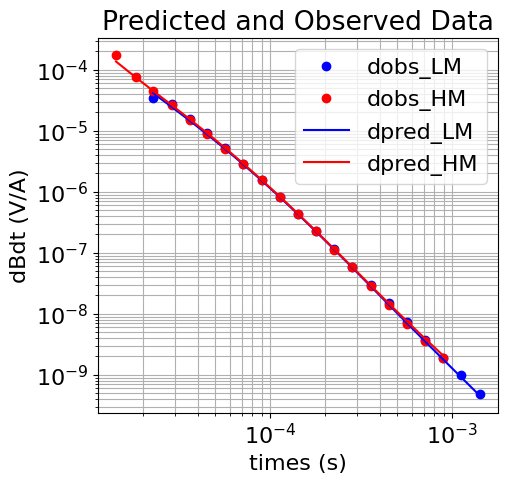

In [27]:
dpred_L2 = simulation.dpred(recovered_model)


fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax1.loglog(time_LM, dobs_LM, "bo",  label='dobs_LM')
ax1.loglog(time_HM, dobs_HM, "ro", label='dobs_HM')
ax1.loglog(time_LM, -dpred_L2[19:], "b-", label='dpred_LM')
ax1.loglog(time_HM, -dpred_L2[:19], "r-", label='dpred_HM')
ax1.grid(which="both")
ax1.set_xlabel("times (s)")
ax1.set_ylabel("dBdt (V/A)")
ax1.set_title("Predicted and Observed Data")
ax1.legend(loc="upper right")
plt.show()

In [28]:
dpred_L2_HM = dpred_L2[:19]
dpred_L2_LM = dpred_L2[19:]

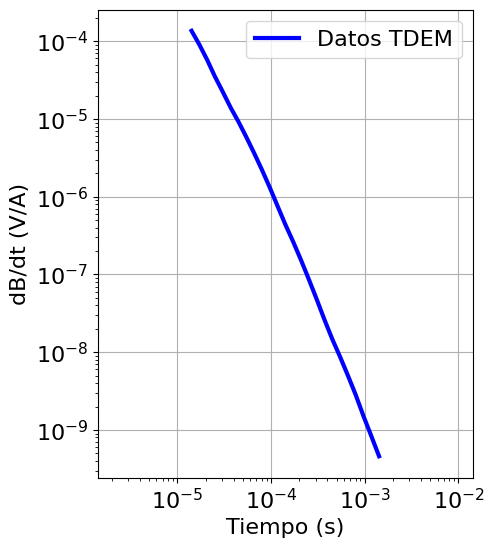

In [29]:
from scipy import interpolate
x = np.concatenate((time_HM, time_LM))
y = np.concatenate((-dpred_L2_HM, -dpred_L2_LM))
f = interpolate.interp1d(x, y)

times_okk = np.logspace(np.log10(np.min(time_HM)),np.log10(np.max(time_LM)),25)
dpredTDEM_okk = f(times_okk)   # use interpolation function returned by `interp1d`



fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])
ax.loglog(times_okk, dpredTDEM_okk, "b-", lw=3, label='Datos TDEM')
#ax.loglog(xnew, ynew, "r--", lw=3, label='dpred_HM')

#ax.loglog(time_LM, dobs_LM, "b.",  label='dobs_LM')
#ax.loglog(time_HM, dobs_HM, "r.", label='dobs_HM')

ax.set_xlim([time_HM.min()/10, 10*time_LM.max()])
#ax.set_ylim([1e-12, 1e-2])

ax.grid()
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel("dB/dt (V/A)")
#ax.set_title("Magnetic Flux Time Derivative")
ax.legend()
plt.show()

In [30]:
rhoa_TDEM1 = rhoafromU(U= dpredTDEM_okk, t= times_okk, Tx= 1600, Rx= 1)

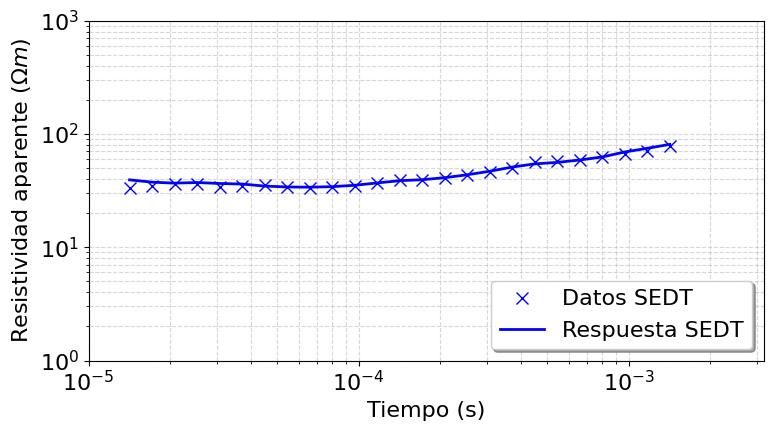

In [31]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax.loglog(times_ok, rhoa_TDEM, "b", marker="x",markersize=8, lw=2, linestyle='none', label='Datos SEDT')
ax.loglog(times_okk, rhoa_TDEM1, "b-", lw=2, label='Respuesta SEDT')
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel(r"Resistividad aparente ($\Omega m$)")

ax.set_ylim([10**0, 10**3])
ax.set_xlim([10**-5, 10**-2.5])
ax.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
plt.legend(loc='lower right', frameon=True, shadow=True, fancybox=True)

#plt.tight_layout()
plt.savefig("respuestaSEDTPiedecuesta.svg", dpi=300, bbox_inches='tight', format='svg')

#filename = "DatosSEDT.png"
#plt.savefig(filename, dpi=300, bbox_inches='tight', format='png')
plt.show()

In [32]:
# Convertir de tiempo a ab2
Ldpred = 711.8 * np.sqrt(times_okk * rhoa_TDEM1)

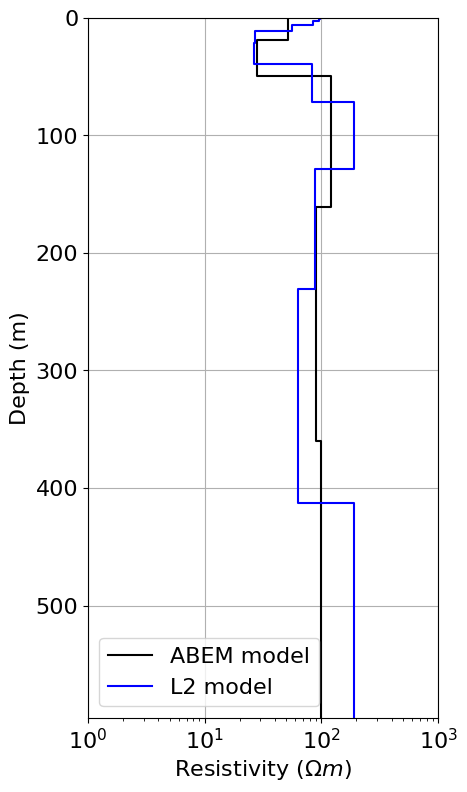

In [33]:
# Graficar el modelo obtenido y compararlo con el modelo obtenido por el equipo
fig = plt.figure(figsize=(5, 10))


# Conductividades
true_conductivities = 1/np.r_[52,28, 120, 90, 100,100]

# Espesores
true_thicknesses = np.r_[19, 31, 111, 199, 131]

ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
plot_1d_layer_model(true_thicknesses, 1/true_conductivities, ax=ax1, color="k", label="ABEM model")
plot_1d_layer_model(
    layer_thicknesses, model_map * recovered_model, ax=ax1, color="b", label="L2 model"
)
ax1.grid()
ax1.set_xlabel(r"Resistivity ($\Omega m$)")
x_min, x_max = 1/true_conductivities.min(), 1/true_conductivities.max()
ax1.set_xlim(1e0, 1e3)
#ax1.set_ylim([600, 0])
#ax1.set_ylim([1.5*np.sum(true_thicknesses), 0])

ax1.legend()
plt.show()

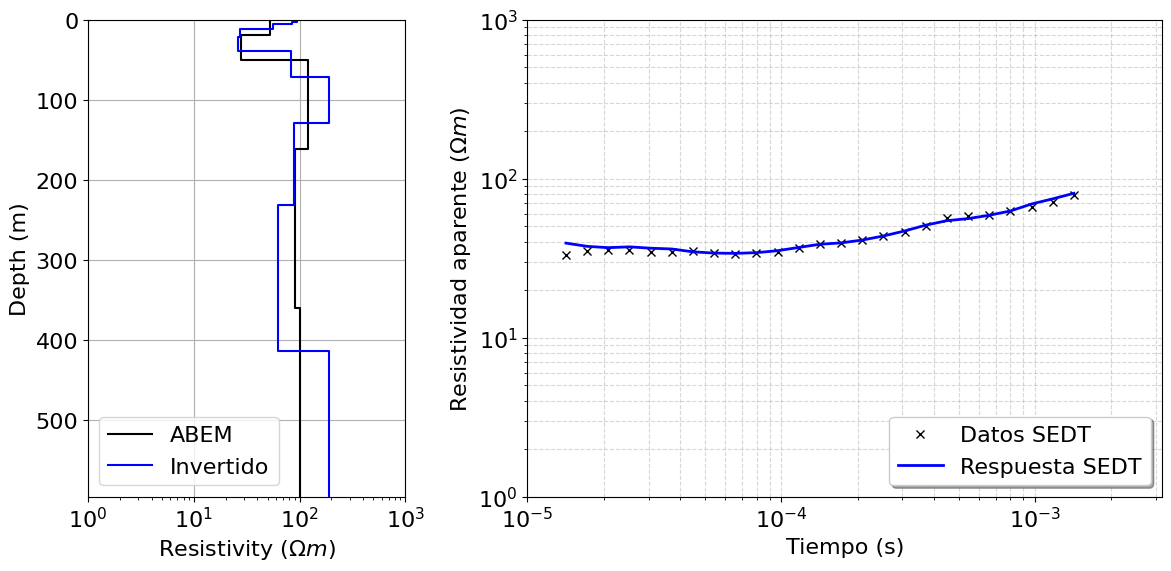

In [34]:
import matplotlib.gridspec as gridspec

# Crear la figura y la configuración de gridspec
fig = plt.figure(figsize=(12, 6))  # Figura más ancha para acomodar ambos gráficos
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])  # 1 fila, 2 columnas (la derecha más ancha)

# Primer subplot (modelo de resistividades)
ax1 = fig.add_subplot(gs[0])
plot_1d_layer_model(true_thicknesses, 1/true_conductivities, ax=ax1, color="k", label="ABEM")
plot_1d_layer_model(
    layer_thicknesses, model_map * recovered_model, ax=ax1, color="b", label="Invertido"
)
ax1.grid()
ax1.set_xlabel(r"Resistivity ($\Omega m$)")
ax1.set_xlim(1e0, 1e3)
ax1.legend()

# Segundo subplot (datos de resistividad aparente)
ax2 = fig.add_subplot(gs[1])
ax2.loglog(times_ok, rhoa_TDEM, "k", marker="x", lw=2, linestyle='none', label='Datos SEDT')
ax2.loglog(times_okk, rhoa_TDEM1, "b-", lw=2, label='Respuesta SEDT')
ax2.set_xlabel("Tiempo (s)")
ax2.set_ylabel(r"Resistividad aparente ($\Omega m$)")
ax2.set_ylim([10**0, 10**3])
ax2.set_xlim([10**-5, 10**-2.5])
ax2.grid(True, which="both", linestyle='--', alpha=0.5)
ax2.legend(loc='lower right', frameon=True, shadow=True, fancybox=True)

# Ajustar el espacio entre subplots
plt.tight_layout()

# Guardar la figura
plt.savefig("Modelo_y_Respuesta_SEDT_Piedecuesta.png", dpi=300, bbox_inches='tight', format='png')

plt.show()

In [35]:
model_map * recovered_model

array([ 97.29749254,  95.20127369,  84.89099081,  56.21714151,
        27.17776221,  26.30932234,  83.34982539, 191.7014854 ,
        87.91631397,  63.07920065, 190.0711832 ])

In [36]:
modelo = model_map * recovered_model

## Respuesta SEV

Survey

In [37]:
# Lee los datos desde el archivo CSV
file_path = 'Datos1.SEV_TDEM_AMT/SEVOK.csv'
datos = pd.read_csv(file_path)

# Obtener datos del archivo CSV
mn_over_2 = datos["MN/2"].values  # Separación MN/2
ab_over_2 = datos["AB/2"].values  # Separación AB/2
dobs = datos["R.A"].values  # Resistividad aparente
error = datos["%error"].values  # Desviación estándar

# Crear las posiciones de los electrodos basadas en las separaciones
# Asumimos que los electrodos están dispuestos linealmente
n_data = len(ab_over_2)
electrode_positions = np.zeros((n_data * 4, 3))  # 4 electrodos por dato (A, B, M, N)

for i in range(n_data):
    # Electrodos A y B a partir de AB/2
    A_pos = [-ab_over_2[i], 0, 0]  # Electrodo A
    B_pos = [ab_over_2[i], 0, 0]   # Electrodo B

    # Electrodos M y N a partir de MN/2
    M_pos = [-mn_over_2[i], 0, 0]  # Electrodo M
    N_pos = [mn_over_2[i], 0, 0]   # Electrodo N

    # Guardamos las posiciones en el array de posiciones
    electrode_positions[i * 4:(i + 1) * 4, :] = [A_pos, B_pos, M_pos, N_pos]

# Crear las combinaciones de fuentes y receptores
source_list = []
for i in range(n_data):
    # Definir los electrodos M y N (receptores)
    M_location = electrode_positions[i * 4 + 2]  # Posición de M
    N_location = electrode_positions[i * 4 + 3]  # Posición de N
    receiver = dc.receivers.Dipole(M_location, N_location, data_type="apparent_resistivity")

    # Definir los electrodos A y B (fuente)
    A_location = electrode_positions[i * 4]      # Posición de A
    B_location = electrode_positions[i * 4 + 1]  # Posición de B
    source = dc.sources.Dipole([receiver], A_location, B_location)

    source_list.append(source)

# Crear el survey
surveySEV = dc.Survey(source_list)

In [38]:
print("# of locations: {}".format(surveySEV.nSrc))  # number of sources
print("# of data: {}".format(surveySEV.nD))  # number of data that will be simulated
print(surveySEV.source_list[17])  # the 3rd source object
print(surveySEV.source_list[17].receiver_list[0])  # Its receiver

# of locations: 19
# of data: 19
Dipole(a: [-90.   0.   0.]; b: [90.  0.  0.])
Dipole(m: [-9.  0.  0.]; n: [9. 0. 0.])


In [39]:
# Modelo hidrogeológico

# Definir espesores de las capas
thicknesses = layer_thicknesses

# Definir resistividades de las capas
model = model_map * recovered_model

# Número de capas
n_layers = len(model)

# Definir mapeo del modelo de conductividad
resistivity_model = model.copy()
model_map = maps.IdentityMap(nP=n_layers)

In [40]:
simulationSEV = dc.simulation_1d.Simulation1DLayers(
    survey=surveySEV,
    rhoMap=model_map,
    thicknesses=thicknesses,
)

dpredSEV = simulationSEV.dpred(model)

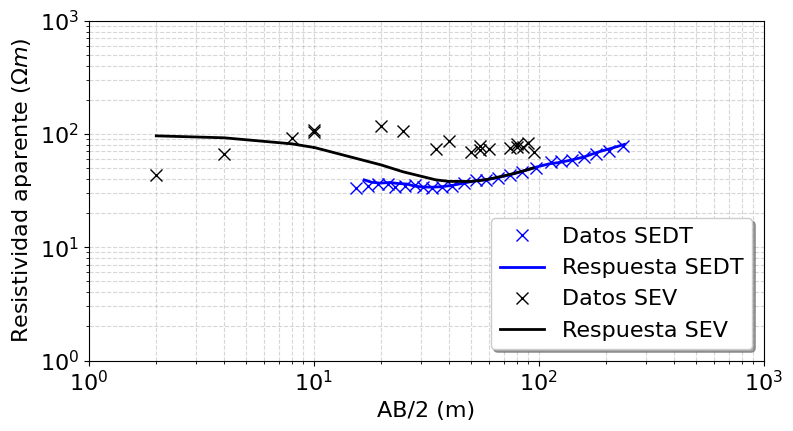

In [41]:
# Graficar la curva de resistividad aparente
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax1.loglog(L, rhoa_TDEM, "blue",  label='Datos SEDT', marker="x",markersize=8, lw=2, linestyle='none')
ax1.loglog(Ldpred, rhoa_TDEM1, "b-", lw=2, label='Respuesta SEDT')
ax1.loglog(ab2, dobsSEV, color="black", label="Datos SEV", marker="x", markersize=8,lw=2, linestyle='none')
ax1.loglog(ab2, dpredSEV, color="black", label="Respuesta SEV", lw= 2)

ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Resistividad aparente ($\Omega m$)")
ax1.set_ylim([10**0, 10**3])
ax1.set_xlim([10**0, 10**3])
ax1.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
plt.legend(loc='lower right', frameon=True, shadow=True, fancybox=True)
plt.savefig("RespuestaSevsinStaticShift.png", dpi=300, bbox_inches='tight', format='png')

plt.show()

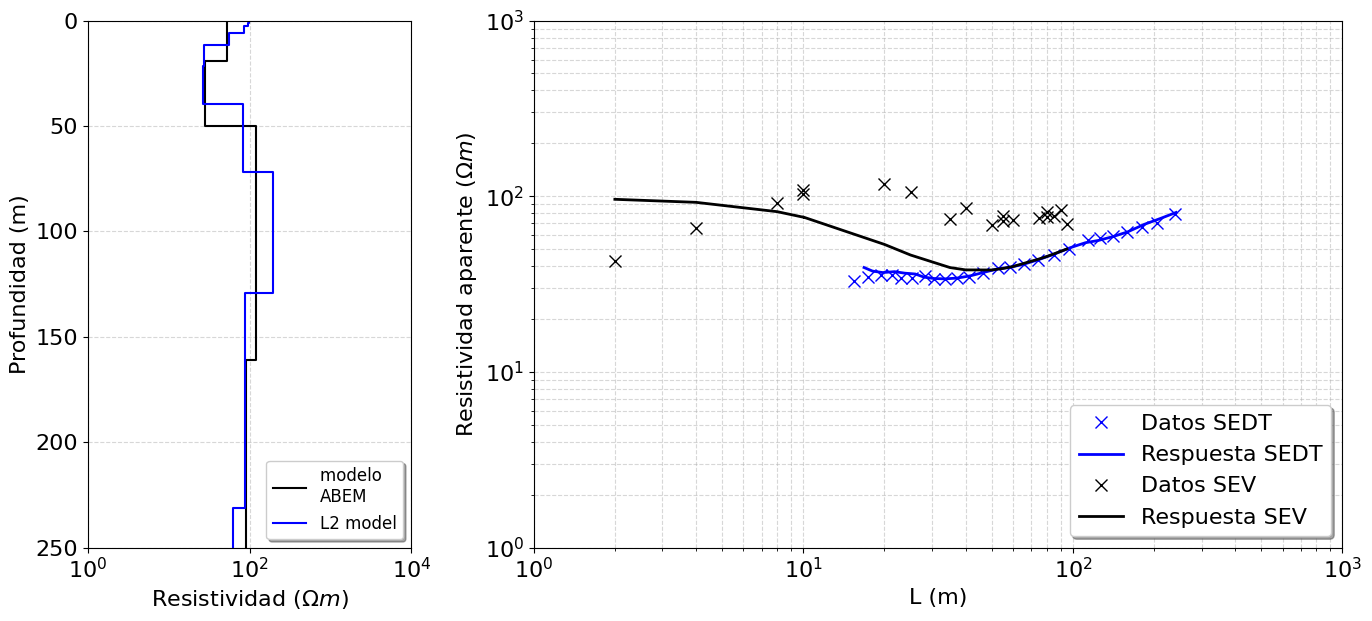

In [48]:
import matplotlib.gridspec as gridspec


# Conductividades
true_conductivities = 1/np.r_[52,28, 120, 90, 100,100]

# Espesores
true_thicknesses = np.r_[19, 31, 111, 199, 131]

# Crear figura y configurar GridSpec
fig = plt.figure(figsize=(14, 12))
gs = gridspec.GridSpec(2, 2, width_ratios=[0.8, 2], height_ratios=[1, 1])

# Primer subplot (izquierda) - Modelo
ax1 = fig.add_subplot(gs[0])
plot_1d_layer_model(true_thicknesses, 1/true_conductivities, ax=ax1, color="k", label="modelo \nABEM")
plot_1d_layer_model(
    layer_thicknesses, modelo, ax=ax1, color="b", label="L2 model"
)
ax1.grid()
ax1.set_xlabel(r"Resistividad ($\Omega m$)")
ax1.grid(True, which="both", linestyle='--', alpha=0.5)
ax1.set_ylabel(r"Profundidad (m)")
ax1.set_xlim(1e0, 1e4)
ax1.set_ylim([250, 0])
ax1.legend(loc='lower right', frameon=True, shadow=True, fancybox=True,fontsize=12)



# Segundo subplot (derecha) - Datos
ax2 = fig.add_subplot(gs[1])
ax2.loglog(L, rhoa_TDEM, "blue",  label='Datos SEDT', marker="x",markersize=8, lw=2, linestyle='none')
ax2.loglog(Ldpred, rhoa_TDEM1, "b-", lw=2, label='Respuesta SEDT')
ax2.loglog(ab2, dobsSEV, color="black", label="Datos SEV", marker="x", markersize=8,lw=2, linestyle='none')
ax2.loglog(ab2, dpredSEV, color="black", label="Respuesta SEV", lw= 2)

ax2.set_xlabel("L (m)")
ax2.set_ylabel(r"Resistividad aparente ($\Omega m$)")
ax2.set_ylim([10**0, 10**3])
ax2.set_xlim([10**0, 10**3])
ax2.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
plt.legend(loc='lower right', frameon=True, shadow=True, fancybox=True)


plt.tight_layout()
plt.savefig("inv_electro_real.svg", dpi=300, bbox_inches="tight", format="svg")
plt.show()


In [49]:
dobsSEV.shape

(19,)

In [50]:
dpredSEV.shape

(19,)

In [54]:
# Calcular el desplazamiento estático

s = np.mean( (dobsSEV)[5:]/ dpredSEV[5:])

print(f"Desplazamiento s = {s:.3f}")

Desplazamiento s = 1.861


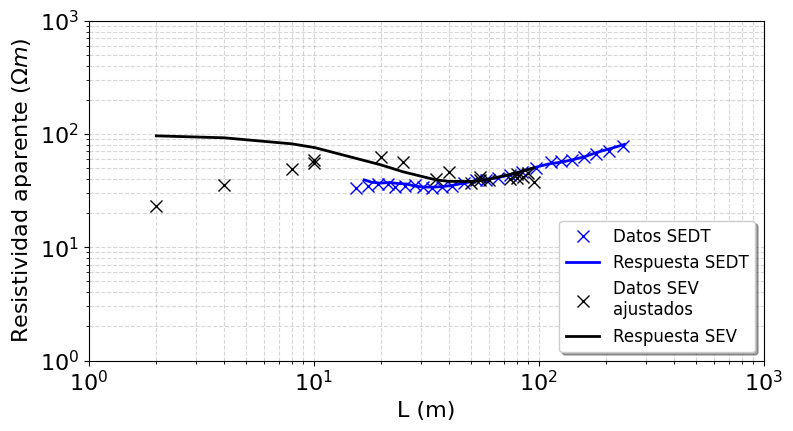

In [59]:
# Graficar la curva de resistividad aparente
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax1.loglog(L, rhoa_TDEM, "blue",  label='Datos SEDT', marker="x",markersize=8, lw=2, linestyle='none')
ax1.loglog(Ldpred, rhoa_TDEM1, "b-", lw=2, label='Respuesta SEDT')
ax1.loglog(ab2, (0.5373455131649651*dobsSEV), color="black", label="Datos SEV\najustados", marker="x", markersize=8,lw=2, linestyle='none')
ax1.loglog(ab2, dpredSEV, color="black", label="Respuesta SEV", lw= 2)

ax1.set_xlabel("L (m)")
ax1.set_ylabel(r"Resistividad aparente ($\Omega m$)")
ax1.set_ylim([10**0, 10**3])
ax1.set_xlim([10**0, 10**3])
ax1.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
plt.legend(loc='lower right', frameon=True, shadow=True, fancybox=True, fontsize=12)
plt.savefig("SEV_real_ajustados.svg", dpi=300, bbox_inches='tight', format='svg')

plt.show()